# Exercise 9.1
## i) Produce plots of the error trajectory

In [22]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(20)

SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 28
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [23]:
Z0 = np.matrix([0,0]).T          # Z0 mean
P0 = np.matrix([[1,0],[0,1]])    # Z0 covariance
R = 3                            # Observation error
Nt = 199                         # N timesteps
dt = 1                           # dt
Nout = 1                         # time between observations  
t = np.arange(0,(Nt+1)*dt,dt)    # time vector
it = np.arange(0,Nt+1)           # time index
D = np.matrix([[0.5,0],[0.2,4]]) # Evolution matrix of dynamical system
Q = np.array([[2,0],[0,2]])      # Covariance matrix of dynamical system
H = np.matrix([1,0])             # Observation matrix

In [24]:
def discreteTimeSystem(Z_prev,Q,D):
    '''
    Iterate the dynamical system once
    '''
    Z = D@Z_prev + np.matrix(np.random.multivariate_normal(np.array([0,0]),Q)).T
    return(Z)

def observation(H,Zk,R):
    '''
    Make single observation from state of the dynamical system
    '''
    Yk = H@Zk + np.random.normal(0,R)
    return Yk

def KalmanFilter(Z0, P0, yobs, R, Nout, dt, D):
    '''
    Kalman Filter as described in Algorithm 6.3
    '''
    zka_prev = Z0
    Pka_prev = P0
    mask = ~np.isnan(yobs)
    yobs = yobs[mask]
    zka_traj_short = np.zeros([2,len(yobs)])
    zka_traj = np.zeros([2,len(mask)])
    
    for iy, y in enumerate(yobs):
        for n in range(Nout):
            zka = (dt*D)@zka_prev
            Pka = (dt*D)@Pka_prev@(dt*D).T + 2*dt*Q

            zka_prev = zka
            Pka_prev = Pka

        zkf = zka_prev
        Pkf = Pka_prev

        K = H@(Pkf@H.T)@np.linalg.inv((R+H@Pkf@H.T))
        
        zka_prev = zkf - K@(H@zkf-y)
        Pka_prev = Pkf - K@H@Pkf
        
        zka_traj_short[:,iy] = np.array(zka_prev).flatten()
    zka_traj[:,mask] = zka_traj_short
    zka_traj[:,~mask] = np.nan
    
    return(zka_traj)

In [25]:
dTS_traj = np.zeros([2,Nt+1])                   # Trajectory of dynamical system

dTS_traj[:,0] = np.array(Z0).flatten()          # Initial state as first entry in trajectory

Z = Z0
for n in range(Nt):
    dTS = discreteTimeSystem(Z,Q,D)
    dTS_traj[:,n+1] = np.array(dTS).flatten()
    Z = dTS

In [26]:
obs_traj = np.zeros(Nt+1)                           # Trajectory of observations
obs_traj[:] = np.nan

for i in it[2::Nout]:
    obs_traj[i] = observation(H, dTS_traj[:,i], R)

In [27]:
zka_traj = KalmanFilter(Z0, P0, obs_traj, R, Nout, dt, D) # Apply Kalman Filter

### Visualise error trajectories

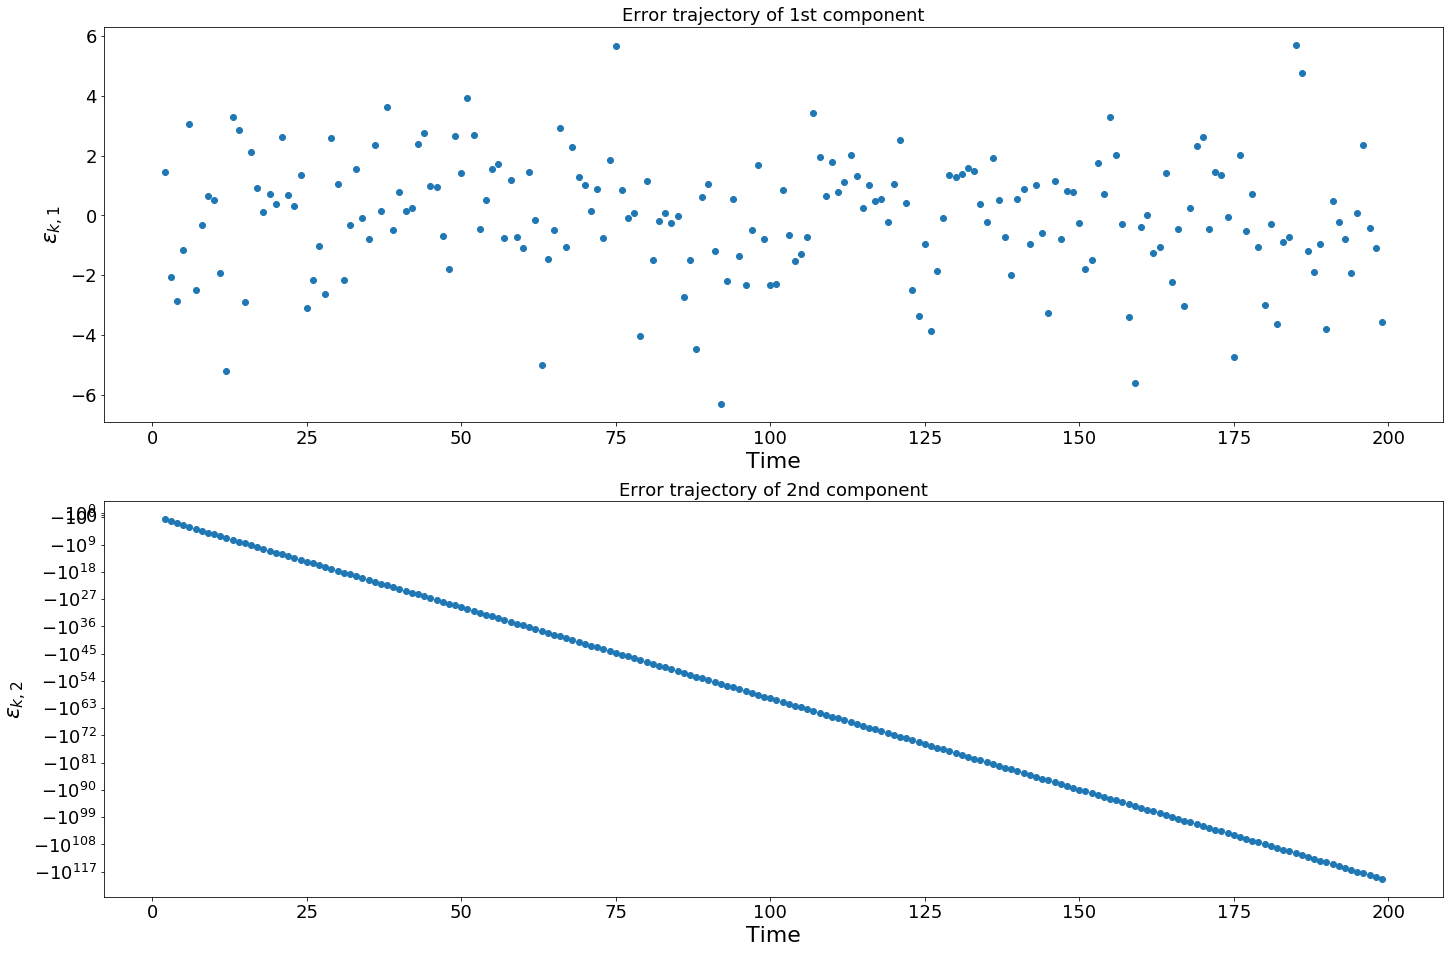

In [8]:
eps0 = zka_traj[0,:]-dTS_traj[0,:]
eps1 = zka_traj[1,:]-dTS_traj[1,:]

fig, axarr = plt.subplots(2,1, figsize=(24,16))

axarr[0].scatter(t, eps0)
axarr[0].set_xlabel('Time')
axarr[0].set_ylabel('$\epsilon_{k,1}$')
axarr[0].set_title('Error trajectory of 1st component')

axarr[1].scatter(t, eps1)
axarr[1].set_xlabel('Time')
axarr[1].set_ylabel('$\epsilon_{k,2}$')
axarr[1].set_title('Error trajectory of 2nd component')
axarr[1].set_yscale('symlog')


plt.show()

## ii) What do you notice about ek for each component? Briefly explain why ek behaves this way.

The first component is very random, rapidly oscilating around the zero mark. The second component is exponantially going into infinity. It is increased by $4^n$. Where N id equal to the number of iterations. Either to positive infinity or negative infinity, based on the initial value Z0. This behaviour is probably because of the 4 in the second component of the D matrix that is multiplied with Zk in the discrete time system model. The oscillating and random behaviour can be explained with the random component that changes Zk every step.

The reason for the error in the second component being so large is that it is not observed. Therefore we do not have much information about it to use it to infer a new analysis mean. 

## iii) Modify the observation setup to improve the performance of the Kalman Filter.
With the given setup only the first component of the dynamical system is observed. The second component of $Z_k$ ($Z_{k_2}$) is, however, dominated by the second component of $Z_{k-1}$ ($Z_{k-1_2}$):

$Z_{k_2} \propto 0.2 \cdot Z_{k-1_1} + 4 \cdot Z_{k-1_2}$

Therefore the Kalman filter should be improved by observing also the second component, which means we have to adjust the observation matrix 

$H = \left[ \begin{array}{cc}
1 & 0 \\ 
\end{array}\right]$ 

to:

$H = \left[ \begin{array}{cc}
1 & 0 \\ 
0 & 1 \\ 
\end{array}\right]$.

In [9]:
H = np.matrix(np.eye(2))
R = np.matrix(np.eye(2) * 3) # We assume the same measurement uncertainty for both components

# Modify observation operator
def observation(H,Zk,R):
    Zk = np.matrix(Zk).T
    Yk = H@Zk + np.matrix(np.random.multivariate_normal(np.array([0,0]),R)).T
    return Yk

In [10]:
# Make full observations
obs_traj = np.zeros((2, Nt+1))
obs_traj[:] = np.nan

for i in it[2::Nout]:
    obs_traj[:,i] = np.array(observation(H, dTS_traj[:,i], R)).flatten()

In [11]:
# Adjust Kalman Filter
def KalmanFilter(Z0, P0, yobs, R, Nout, dt, D):
    zka_prev = Z0
    Pka_prev = P0
    
    mask = ~np.isnan(yobs)
    yobs_temp = np.zeros((2,int(mask.sum()/2)))
    yobs_temp[0,:] = yobs[0,mask[0,:]]
    yobs_temp[1,:] = yobs[1,mask[1,:]]

    yobs = yobs_temp
    
    zka_traj_short = np.zeros_like(yobs)
    zka_traj = np.zeros_like(mask, dtype=np.float)
    
    for iy in range(yobs.shape[1]):
        for n in range(Nout):
            zka = (dt*D)@zka_prev
            Pka = (dt*D)@Pka_prev@(dt*D).T + 2*dt*Q

            zka_prev = zka
            Pka_prev = Pka

        zkf = zka_prev
        Pkf = Pka_prev

        K = Pkf@H.T@np.linalg.inv((R+H@Pkf@H.T))
        zka_prev = zkf - K@(zkf-np.matrix(yobs[:,iy]).T)
        Pka_prev = Pkf - K@Pkf        
        
        zka_traj_short[:,iy] = np.array(zka_prev).flatten()
    
    zka_traj[0,mask[0,:]] = zka_traj_short[0,:]
    zka_traj[1,mask[1,:]] = zka_traj_short[1,:]
    
    zka_traj[0,~mask[0,:]] = np.nan
    zka_traj[1,~mask[1,:]] = np.nan

    
    return(zka_traj)

In [12]:
zka_traj = KalmanFilter(Z0, P0, obs_traj, R, Nout, dt, D) # Apply Kalman Filter

### Visualise trajectories

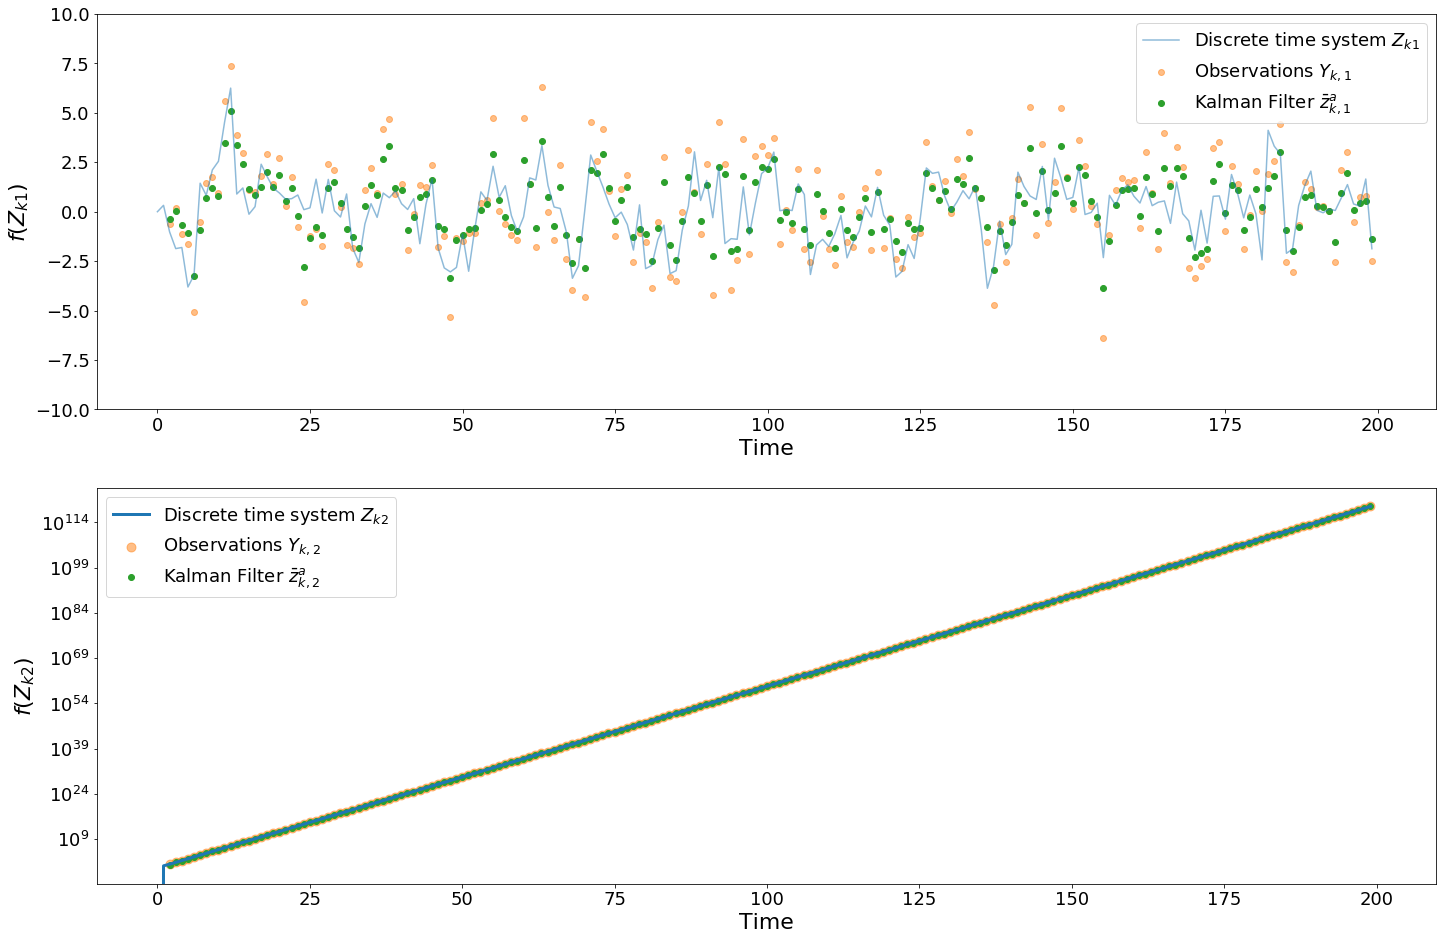

In [13]:
fig, axarr = plt.subplots(2,1,figsize=(24,16))
axarr[0].plot(t, dTS_traj[0,:], alpha=.5, label='Discrete time system $Z_{k1}$')
axarr[0].scatter(t, obs_traj[0,:], alpha=.5, c='C1', label='Observations $Y_{k,1}$')
axarr[0].scatter(t, zka_traj[0,:], c='C2', label=r'Kalman Filter $\bar{z}_{k,1}^a$')
axarr[0].set_ylim([-10,10])
axarr[0].set_ylabel('$f(Z_{k1})$')
axarr[0].set_xlabel('Time')
axarr[0].legend()

axarr[1].plot(t, dTS_traj[1,:], label='Discrete time system $Z_{k2}$', linewidth=3)
axarr[1].scatter(t, obs_traj[1,:], alpha=.5, c='C1', label='Observations $Y_{k,2}$', s=80)
axarr[1].scatter(t, zka_traj[1,:], c='C2', label=r'Kalman Filter $\bar{z}_{k,2}^a$')
axarr[1].legend()
axarr[1].set_yscale('log')
axarr[1].set_xlabel('Time')
axarr[1].set_ylabel('$f(Z_{k2})$')


plt.show()

### Visualise error trajectories

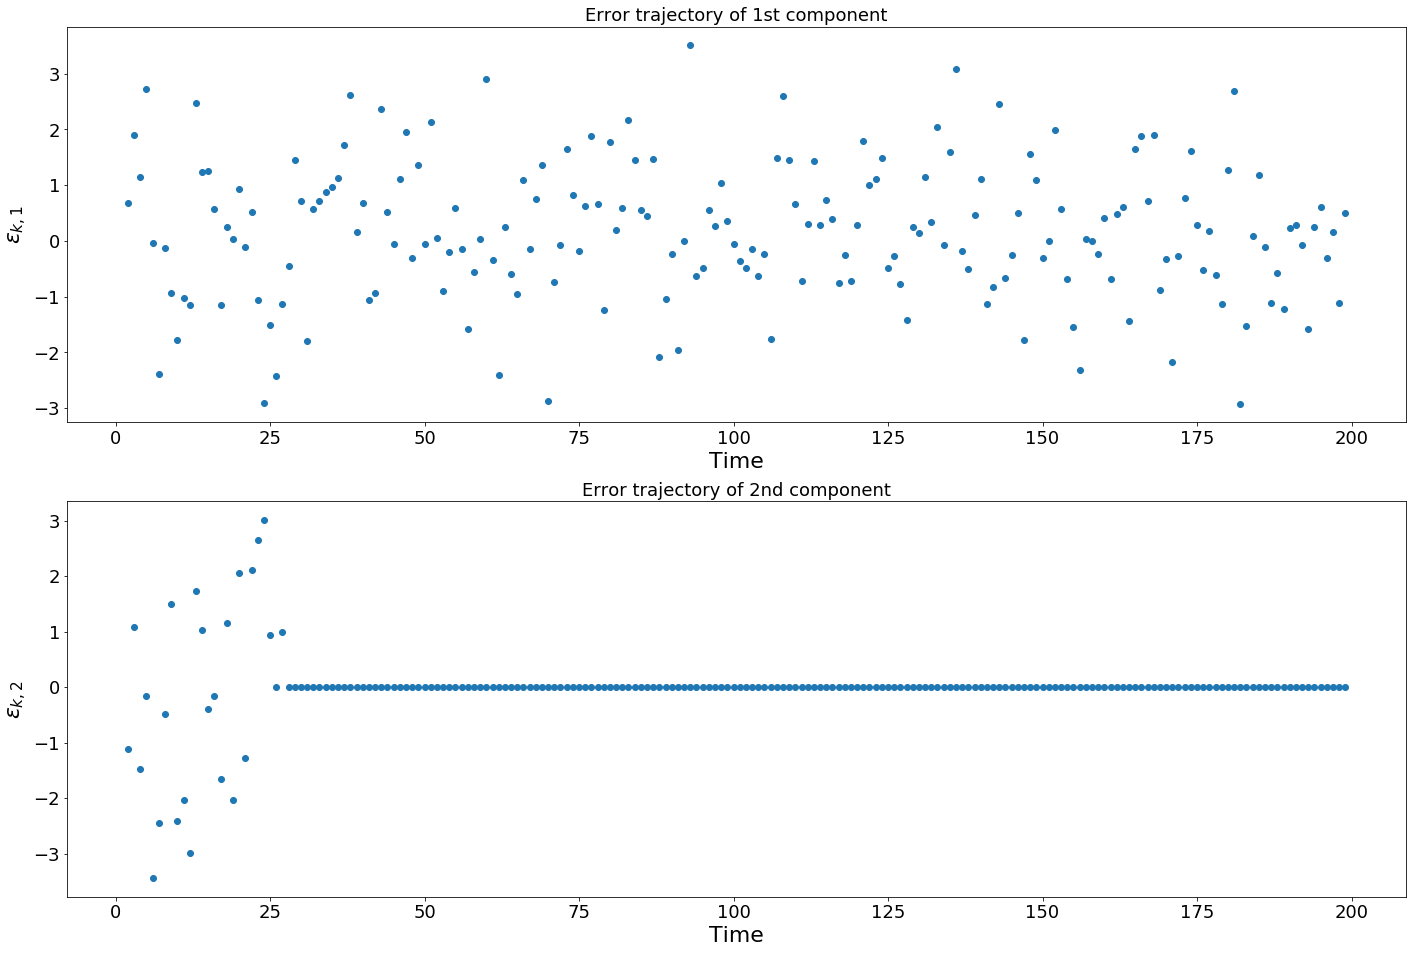

In [14]:
fig, axarr = plt.subplots(2,1,figsize=(24,16))
axarr[0].scatter(t, zka_traj[0,:] - dTS_traj[0,:])
axarr[0].set_xlabel('Time')
axarr[0].set_ylabel('$\epsilon_{k,1}$')
axarr[0].set_title('Error trajectory of 1st component')

axarr[1].scatter(t, zka_traj[1,:] - dTS_traj[1,:])
axarr[1].set_xlabel('Time')
axarr[1].set_ylabel('$\epsilon_{k,2}$')
axarr[1].set_title('Error trajectory of 2nd component')
plt.show()

We can see that the observation of the second component leads to a significantly better estimation of the second component of $Z_k$ via the Kalman Filter.

The above two plots actually should look identical, but due to subtraction of two large floating point numbers the second plot gets 0 eventually.

In [3]:
obs = np.inf

In [2]:
import numpy as np

In [5]:
obs + 5

inf